In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.cluster import KMeans

from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin


import warnings


Acutual NoteBook Code link: https://www.kaggle.com/code/silanmahoot/k-means-clustering

In [2]:
dataSetPath = r"..\1_DataSets\Online_Retail.xlsx"

df = pd.read_excel(dataSetPath)
dataSetName = os.path.basename(dataSetPath)

print(f"Dataset Columns: {df.columns.to_list()}")
print("****************************")
print(f"Dataset Shape: {df.shape}")
print("****************************")

totalNumberOfRowInActualDataset = len(df)
print(f"Total Rows in dataset File: {totalNumberOfRowInActualDataset}")

Dataset Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']
****************************
Dataset Shape: (541909, 8)
****************************
Total Rows in dataset File: 541909


# Explore

In [3]:
df.shape

(541909, 8)

In [4]:
df.drop_duplicates(inplace=True)
print(f"Dataset Shape after removing duplcates: {df.shape}")
print("****************************")

numberOfRowAfterRemovingDuplicates = len(df)
print(f"Remaining Rows in Dataset: {numberOfRowAfterRemovingDuplicates}")

print("****************************")
print(f"Total Duplicates: {(totalNumberOfRowInActualDataset - numberOfRowAfterRemovingDuplicates)}")

# Step 2: Handle missing values (remove rows with missing values)
df = df.dropna()
numberOfRowAfterRemovingNullValues = len(df)
print(f"Remaining Rows in Dataset: {numberOfRowAfterRemovingNullValues}")

print("****************************")
print(f"Removed Number of rows containing Null Values: {( numberOfRowAfterRemovingDuplicates - numberOfRowAfterRemovingNullValues)}")

Dataset Shape after removing duplcates: (536641, 8)
****************************
Remaining Rows in Dataset: 536641
****************************
Total Duplicates: 5268
Remaining Rows in Dataset: 401604
****************************
Removed Number of rows containing Null Values: 135037


In [5]:
df.shape

(401604, 8)

In [6]:
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    401604 non-null  object        
 1   StockCode    401604 non-null  object        
 2   Description  401604 non-null  object        
 3   Quantity     401604 non-null  int64         
 4   InvoiceDate  401604 non-null  datetime64[ns]
 5   UnitPrice    401604 non-null  float64       
 6   CustomerID   401604 non-null  float64       
 7   Country      401604 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.6+ MB


In [8]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,401604.000000,401604,401604.000000,401604.000000
mean,12.183273,2011-07-10 12:08:23.848567552,3.474064,15281.160818
min,-80995.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-06 15:02:00,1.250000,13939.000000
50%,5.000000,2011-07-29 15:40:00,1.950000,15145.000000
75%,12.000000,2011-10-20 11:58:30,3.750000,16784.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,250.283037,NaN,69.764035,1714.006089


# Cleansing

In [9]:
# Drop Description, CustomerID, InvoiceNo and StockCode columns
df.drop(['Description', 'InvoiceNo', 'StockCode', 'InvoiceDate', 'CustomerID'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Quantity   401604 non-null  int64  
 1   UnitPrice  401604 non-null  float64
 2   Country    401604 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 12.3+ MB


In [10]:
# Drop rows with negative Quantity
df = df[df['Quantity'] > 0]

In [11]:
# Drop rows with negative UnitPrice
df = df[df['UnitPrice'] > 0]

In [12]:
# Remove outliers in Quantity
Q1 = df['Quantity'].quantile(0.25)
Q3 = df['Quantity'].quantile(0.75)
IQR = Q3 - Q1 
df = df[(df['Quantity'] >= (Q1 - 1.5 * IQR)) & (df['Quantity'] <= (Q3 + 1.5 * IQR))] 

In [13]:
# Remove outliers in UnitPrice
Q1 = df['UnitPrice'].quantile(0.25)
Q3 = df['UnitPrice'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['UnitPrice'] >= (Q1 - 1.5 * IQR)) & (df['UnitPrice'] <= (Q3 + 1.5 * IQR))]

In [14]:
df.describe()

,Quantity,UnitPrice
count,333234.000000,333234.000000
mean,7.550682,2.194218
std,6.777237,1.546015
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.650000
75%,12.000000,2.950000
max,27.000000,7.500000


# Feature Engineering

In [15]:
# Create new TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# EDA

<Axes: ylabel='Country'>

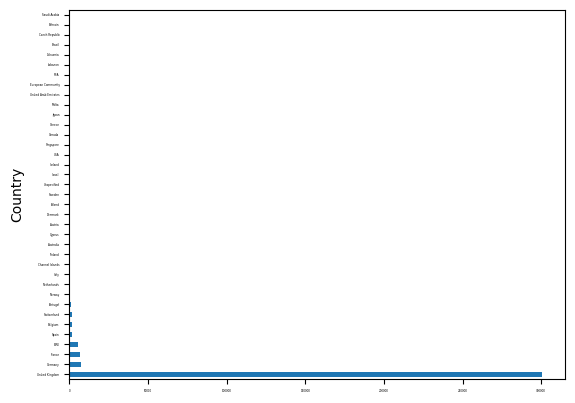

In [16]:
# Frequency of each country
df['Country'].value_counts().plot(kind='barh', fontsize=2)

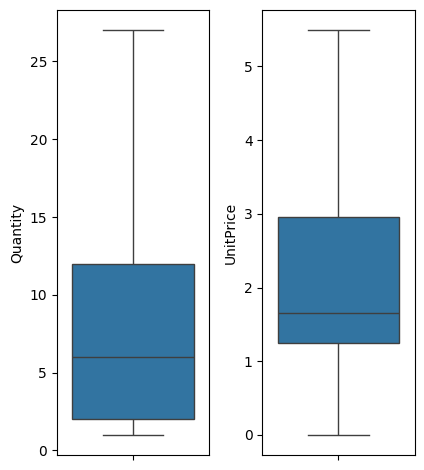

In [17]:
# Boxplot of Quantity and UnitPrice
plt.subplot(1, 3, 1)
sns.boxplot(y='Quantity', data=df, showfliers=False)

plt.subplot(1, 3, 2)
sns.boxplot(y='UnitPrice', data=df, showfliers=False)

plt.tight_layout()

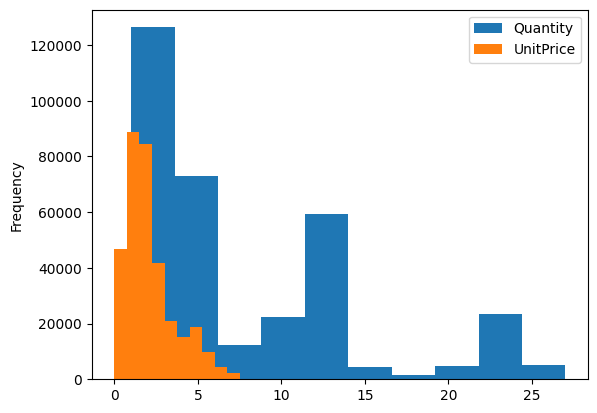

In [18]:
# Histogram of Quantity and UnitPrice
df['Quantity'].plot(kind='hist', bins=10)
df['UnitPrice'].plot(kind='hist', bins=10)

plt.legend(['Quantity', 'UnitPrice'])

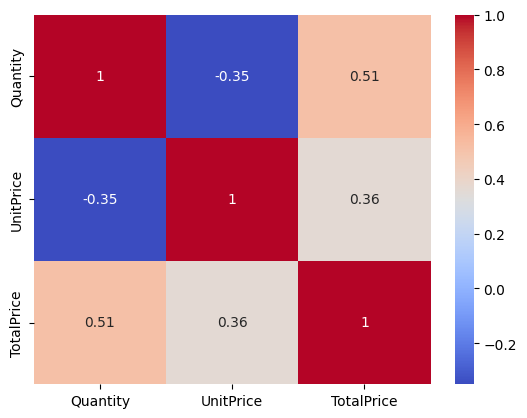

In [19]:
# Correlation matrix
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

# Preprocessing

## Splitting

In [20]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)

## Encoding

In [21]:
# Encode the Country column
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
train['Country'] = encoder.fit_transform(train['Country'])
test['Country'] = encoder.transform(test['Country'])

# Modeling

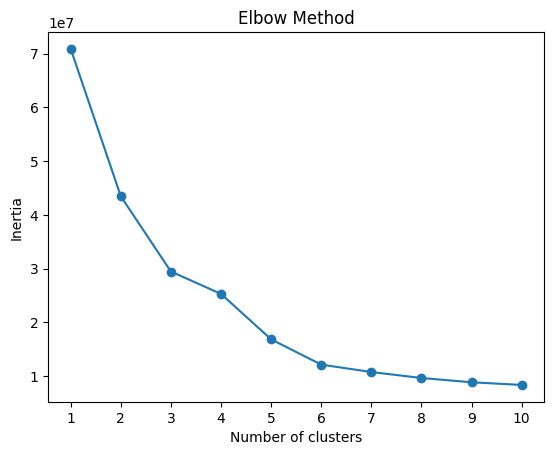

In [22]:
# K-Means Clustering
from sklearn.cluster import KMeans


# Find the best number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(train)
    inertia.append(kmeans.inertia_)
    
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.show()

C:\Users\mubi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


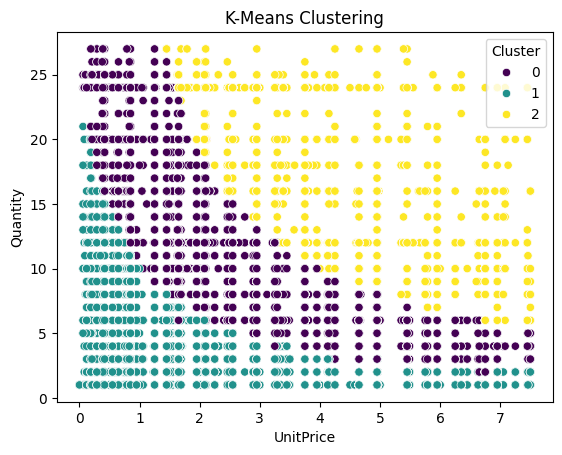

In [23]:
# Fit the model with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
train['Cluster'] = kmeans.fit_predict(train)

# Visualize the clusters
sns.scatterplot(x='UnitPrice', y='Quantity', hue='Cluster', data=train, palette='viridis')
plt.title('K-Means Clustering')
plt.show()

In [24]:
df.head()

,Quantity,UnitPrice,Country,TotalPrice
0,6,2.55,United Kingdom,15.30
1,6,3.39,United Kingdom,20.34
2,8,2.75,United Kingdom,22.00
3,6,3.39,United Kingdom,20.34
4,6,3.39,United Kingdom,20.34


In [25]:
train.head()

,Quantity,UnitPrice,Country,TotalPrice,Cluster
207188,12,0.83,35,9.96,0
210647,20,1.65,35,33.00,0
506384,1,2.08,35,2.08,1
216494,2,4.25,35,8.50,1
358720,8,3.95,35,31.60,0


In [26]:
# Extract relevant features: latitude (lat) and longitude (lng)
coordinates = train[['Country', 'TotalPrice']].values

# Define the number of clusters (k)
k = 5
# K-Means Clustering Process
max_iterations = 30


output_dir = f"kmeans_steps_{dataSetName}_Features_lat_lng"  # Directory to save the plots
# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Initialize random centroids (pick k random points from the data)
np.random.seed(42)
centroids = coordinates[np.random.choice(coordinates.shape[0], k, replace=False)]

# Function to plot clusters and centroids
def plot_clusters(coordinates, labels, centroids, iteration):
    plt.figure(figsize=(10, 6))
    colors = ['red', 'blue', 'green', 'purple', 'orange']
    
    # Plot each cluster
    for cluster in range(k):
        cluster_points = coordinates[labels == cluster]
        plt.scatter(cluster_points[:, 1], cluster_points[:, 0], s=100, color=colors[cluster], label=f'Cluster {cluster + 1}')
    
    # Plot centroids
    plt.scatter(centroids[:, 1], centroids[:, 0], c='black', marker='x', s=200, label='Centroids')
    plt.title(f'K-Means Clustering - Iteration {iteration}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    # Save the plot
    file_name = os.path.join(output_dir, f"iteration_{iteration + 1}.png")
    plt.savefig(file_name)
    #plt.show()
    plt.close()

for iteration in range(1, max_iterations + 1):
    # Assign clusters based on the closest centroid
    labels = pairwise_distances_argmin(coordinates, centroids)
    
    # Plot the current state of clusters and centroids
    plot_clusters(coordinates, labels, centroids, iteration)
    
    # Recalculate centroids as the mean of assigned points
    new_centroids = np.array([coordinates[labels == cluster].mean(axis=0) for cluster in range(k)])
    
    # Check for convergence (if centroids do not change)
    if np.all(centroids == new_centroids):
        print(f"Convergence reached at iteration {iteration}")
        break
    
    centroids = new_centroids

C:\Users\mubi\AppData\Local\Temp\ipykernel_2300\3092429146.py:49: RuntimeWarning: Mean of empty slice.
  new_centroids = np.array([coordinates[labels == cluster].mean(axis=0) for cluster in range(k)])
c:\Users\mubi\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


ValueError: Input contains NaN.

In [27]:
train.head()

,Quantity,UnitPrice,Country,TotalPrice,Cluster
207188,12,0.83,35,9.96,0
210647,20,1.65,35,33.00,0
506384,1,2.08,35,2.08,1
216494,2,4.25,35,8.50,1
358720,8,3.95,35,31.60,0


C:\Users\mubi\AppData\Local\Temp\ipykernel_2300\1656508479.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(file_name)
C:\Users\mubi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


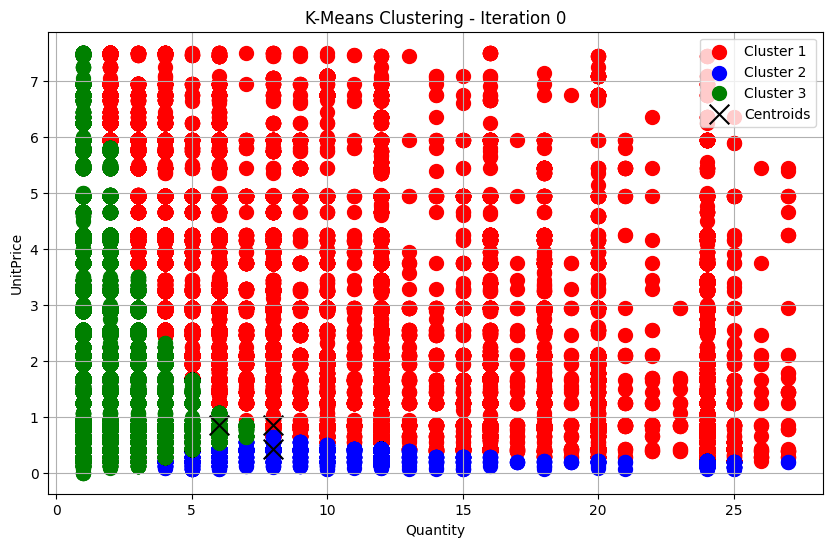

C:\Users\mubi\AppData\Local\Temp\ipykernel_2300\1656508479.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(file_name)
C:\Users\mubi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


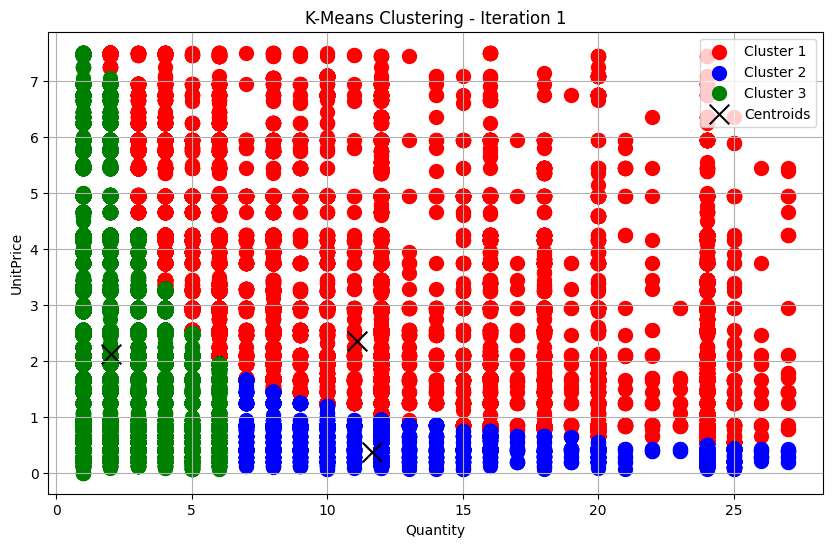

C:\Users\mubi\AppData\Local\Temp\ipykernel_2300\1656508479.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(file_name)
C:\Users\mubi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


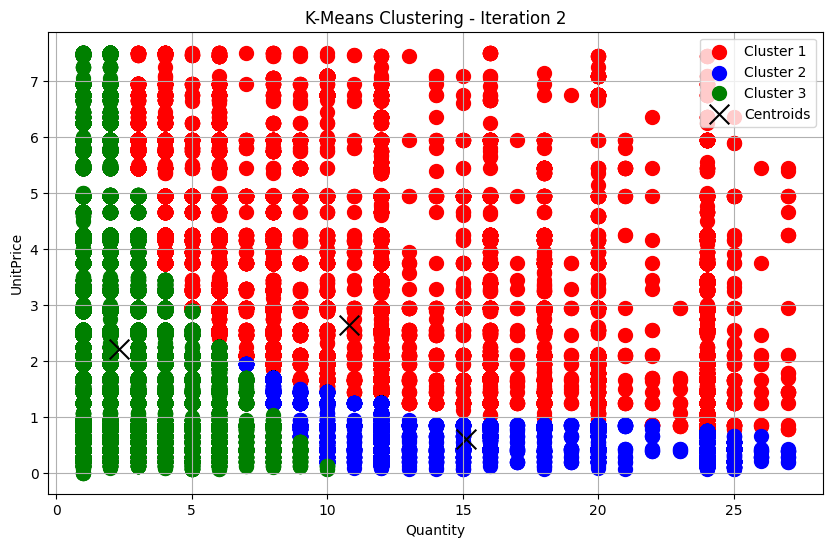

C:\Users\mubi\AppData\Local\Temp\ipykernel_2300\1656508479.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(file_name)
C:\Users\mubi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


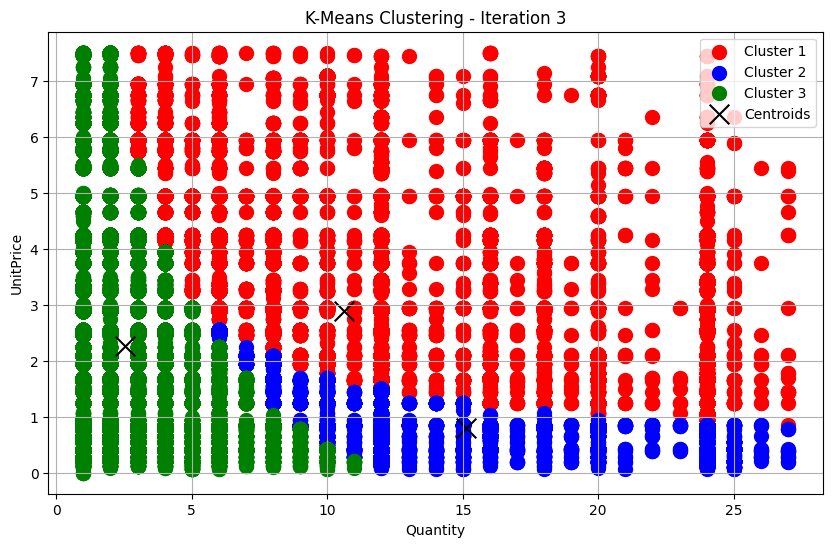

C:\Users\mubi\AppData\Local\Temp\ipykernel_2300\1656508479.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(file_name)
C:\Users\mubi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


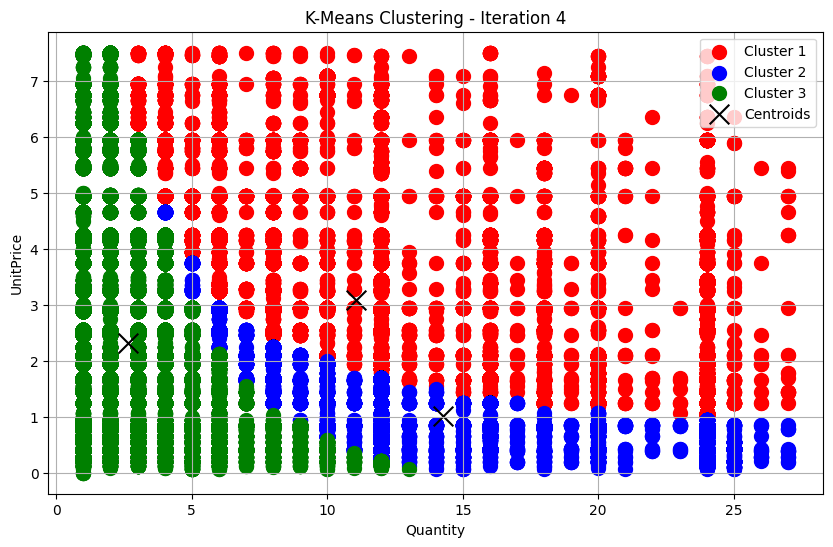

C:\Users\mubi\AppData\Local\Temp\ipykernel_2300\1656508479.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(file_name)
C:\Users\mubi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


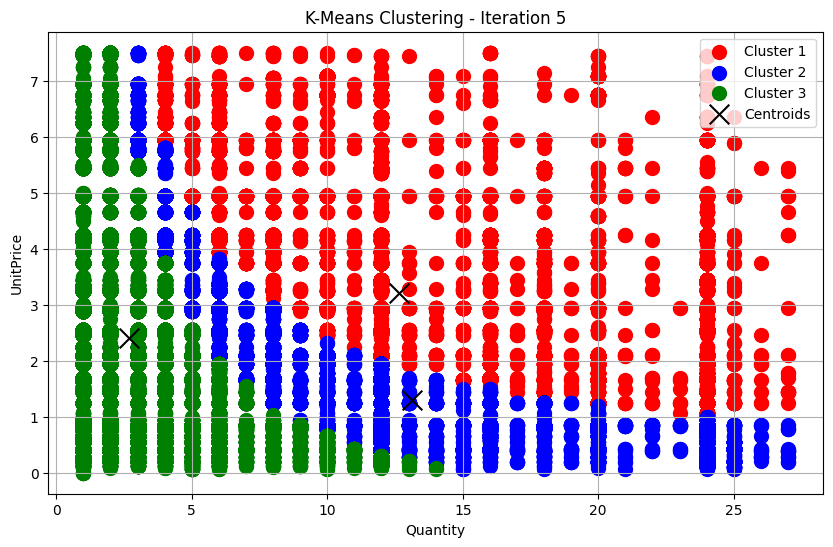

C:\Users\mubi\AppData\Local\Temp\ipykernel_2300\1656508479.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(file_name)
C:\Users\mubi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


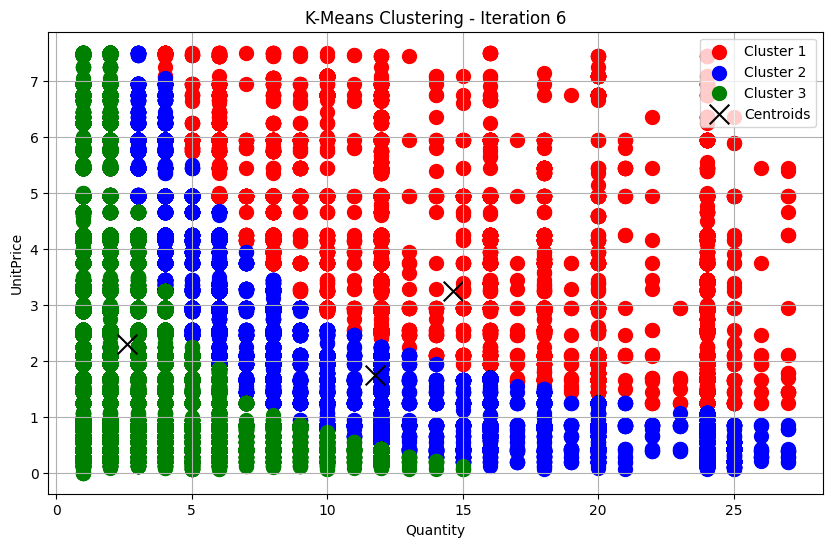

C:\Users\mubi\AppData\Local\Temp\ipykernel_2300\1656508479.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(file_name)
C:\Users\mubi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


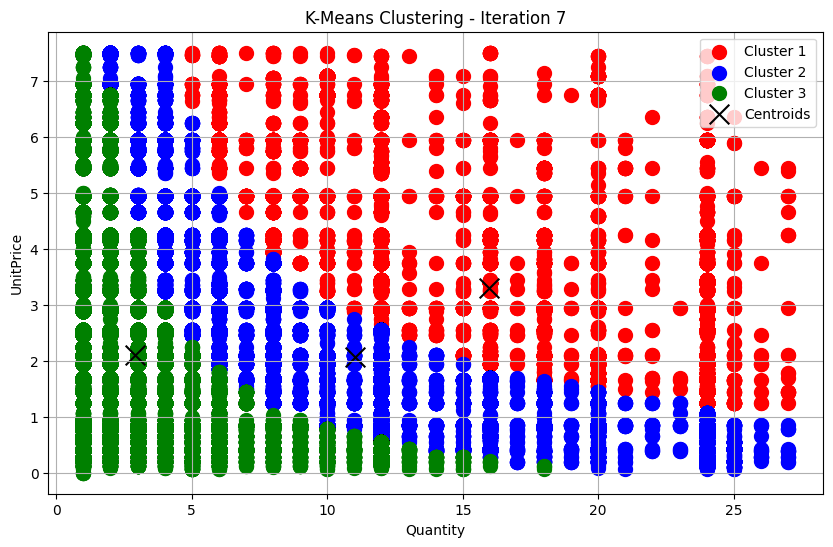

C:\Users\mubi\AppData\Local\Temp\ipykernel_2300\1656508479.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(file_name)
C:\Users\mubi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


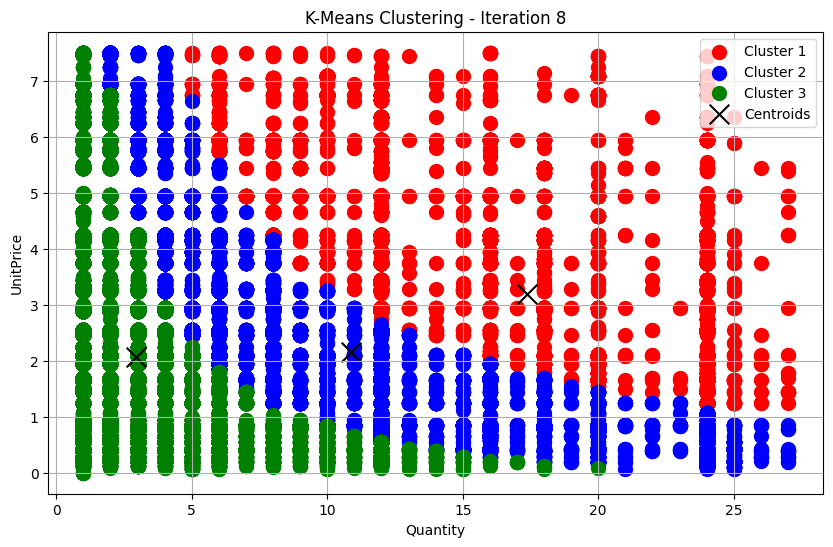

C:\Users\mubi\AppData\Local\Temp\ipykernel_2300\1656508479.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(file_name)
C:\Users\mubi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


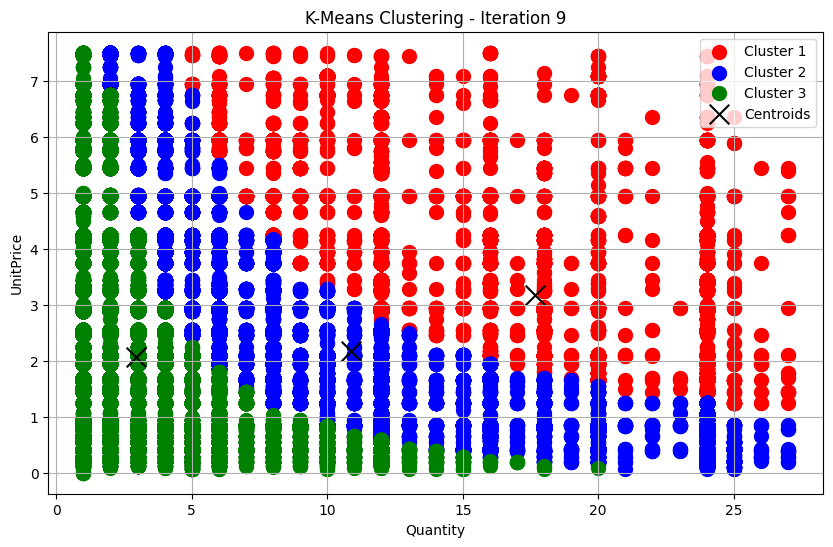

C:\Users\mubi\AppData\Local\Temp\ipykernel_2300\1656508479.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(file_name)
C:\Users\mubi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


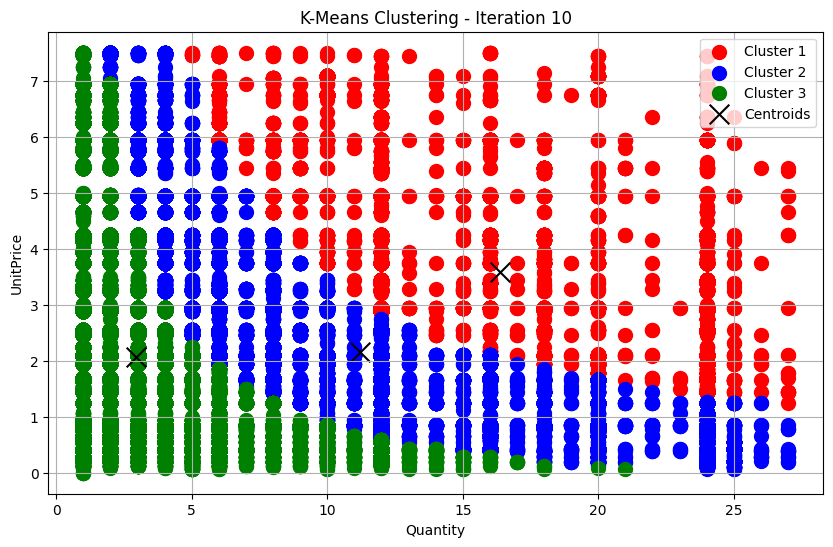

C:\Users\mubi\AppData\Local\Temp\ipykernel_2300\1656508479.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(file_name)
C:\Users\mubi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


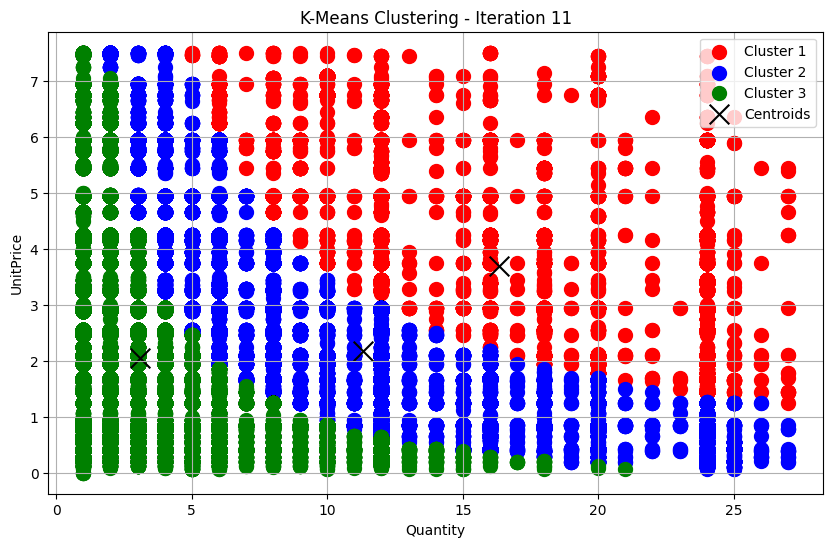

C:\Users\mubi\AppData\Local\Temp\ipykernel_2300\1656508479.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(file_name)
C:\Users\mubi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


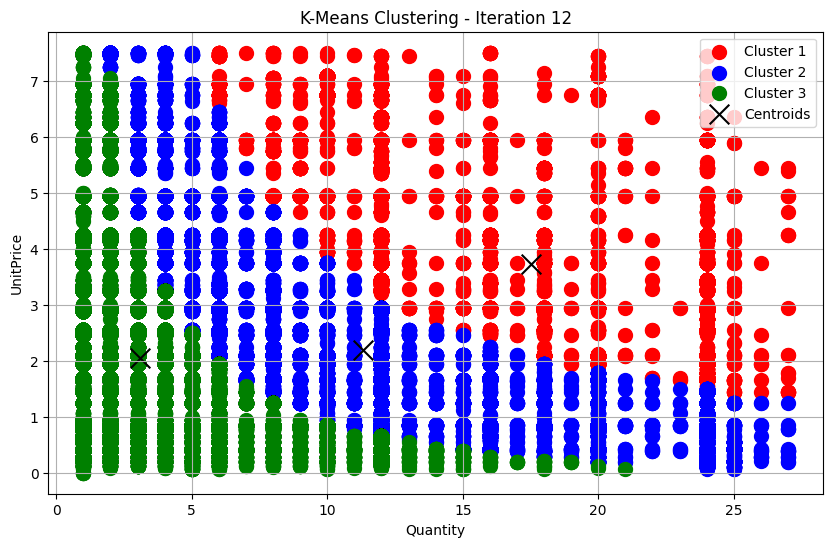

C:\Users\mubi\AppData\Local\Temp\ipykernel_2300\1656508479.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(file_name)
C:\Users\mubi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


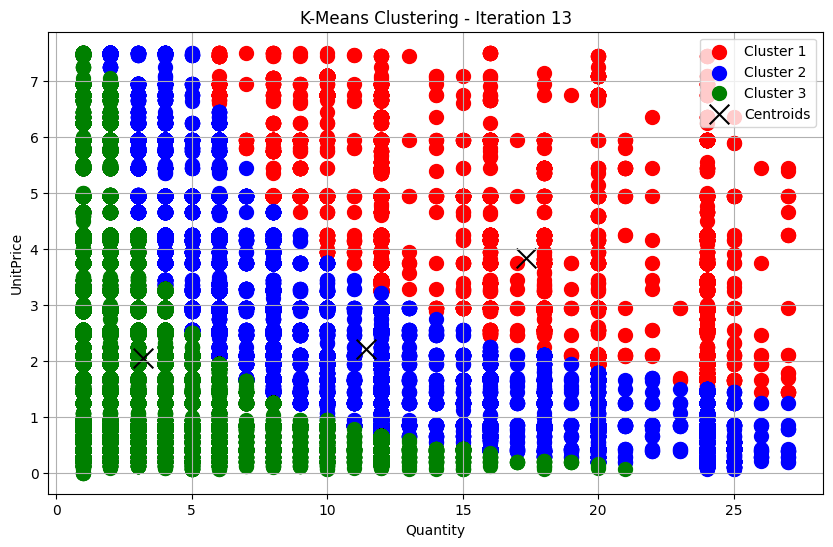

C:\Users\mubi\AppData\Local\Temp\ipykernel_2300\1656508479.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(file_name)
C:\Users\mubi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


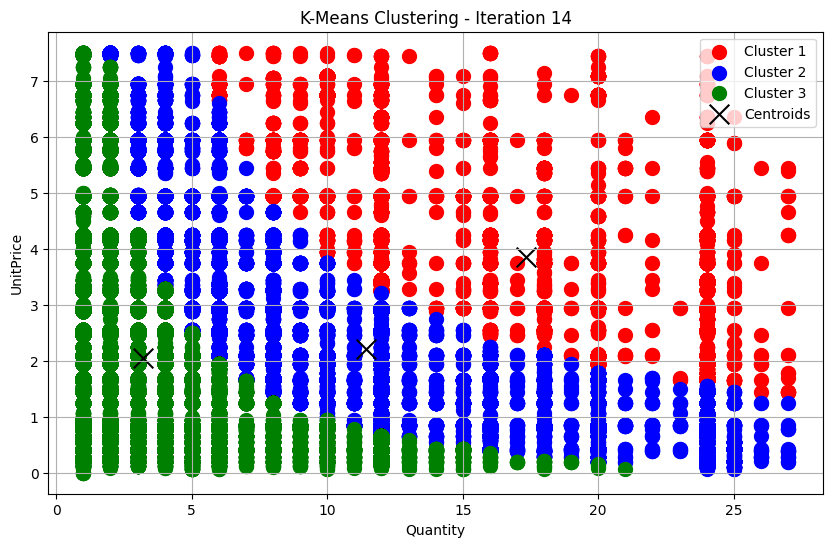

C:\Users\mubi\AppData\Local\Temp\ipykernel_2300\1656508479.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(file_name)
C:\Users\mubi\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


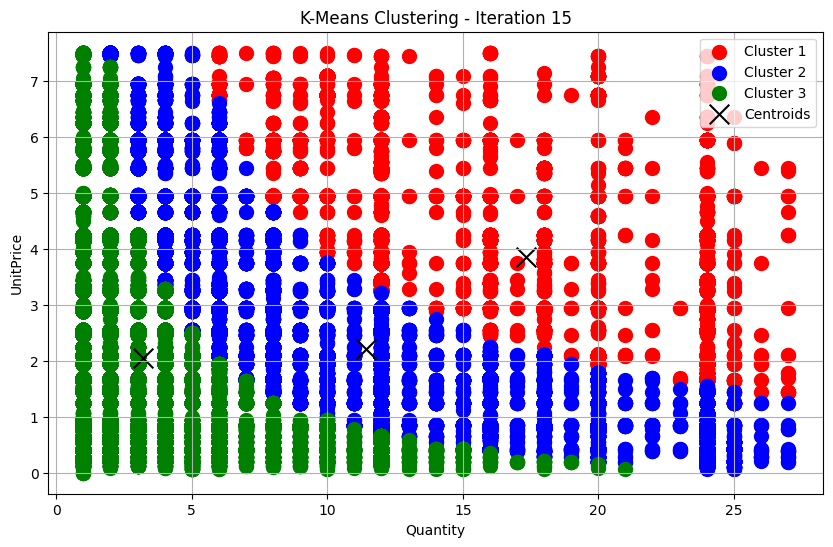

Convergence reached at iteration 15


In [28]:
# Extract features for clustering
features = train[["Quantity", "UnitPrice", "TotalPrice"]].values

# Define the number of clusters (k)
k = 3
output_dir = "kmeans_steps_online_retail"  # Directory to save the plots

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Initialize random centroids (pick k random points from the data)
np.random.seed(42)
centroids = features[np.random.choice(features.shape[0], k, replace=False)]

# Function to plot clusters and centroids
def plot_clusters(features, labels, centroids, iteration):
    plt.figure(figsize=(10, 6))
    colors = ['red', 'blue', 'green', 'purple', 'orange']
    
    # Plot each cluster
    for cluster in range(k):
        cluster_points = features[labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=100, color=colors[cluster], label=f'Cluster {cluster + 1}')
    
    # Plot centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=200, label='Centroids')
    plt.title(f'K-Means Clustering - Iteration {iteration}')
    plt.xlabel('Quantity')
    plt.ylabel('UnitPrice')
    plt.legend()
    plt.grid(True)
    # Save the plot
    file_name = os.path.join(output_dir, f"iteration_{iteration + 1}.png")
    plt.savefig(file_name)
    plt.show()
    plt.close()

# K-Means Clustering Process
max_iterations = 20
for iteration in range(max_iterations):
    # Assign clusters based on the closest centroid
    labels = pairwise_distances_argmin(features, centroids)
    
    # Plot the current state of clusters and centroids
    plot_clusters(features, labels, centroids, iteration)
    
    # Recalculate centroids as the mean of assigned points
    new_centroids = np.array([features[labels == cluster].mean(axis=0) for cluster in range(k)])
    
    # Check for convergence (if centroids do not change)
    if np.all(centroids == new_centroids):
        print(f"Convergence reached at iteration {iteration}")
        break
    
    centroids = new_centroids